# An LLM-Approach to Semantic Clustering and Topic Modeling of Academic Literature

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) stands as a fundamental task in unsupervised learning, where the goal is to group unlabeled data into related categories; whereas [Topic Modeling](https://en.wikipedia.org/wiki/Topic_model) focuses on identifying thematic structures within a collection of documents. These techniques find applications across various domains, enabling tasks such as information retrieval, anomaly detection, trend analysis, and biomedical research.

This notebook provides an end-to-end guide to building an LLM-based pipeline for automatic categorization of research articles into latent topics using open-source tools and models. Our playground is a  [dataset of 25,000 research arXiv publications](https://huggingface.co/datasets/dcarpintero/arxiv.cs.CL.25k) from Computational Linguistics (Natural Language Processing) published before July 2024.

At its core, the clustering problem relies on finding similar examples. This is a natural task for embeddings, as they capture the semantic relationships in a corpus, and can be provided as input features to a clustering algorithm to establish similarity links among the examples. We begin by transforming the `title:abstract` pairs of our dataset into an embeddings representation using  [Jina-Embeddings-v2](https://arxiv.org/abs/2310.19923), a BERT-ALiBi based attention model supporting 8192 sequence length, and subsequently applying HDBSCAN [2] in a reduced dimensional space. Topic modeling is then performed at cluster level using a random subset of `titles` within each cluster. This latter process combines [LangChain](https://www.langchain.com/) and [Pydantic](https://docs.pydantic.dev/) with [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2) to construct a topic pipeline that generates structured `JSON` output.

To measure the clustering and topic modeling effectiveness, we visualize the outcomes after further applying [UMAP](https://en.wikipedia.org/wiki/Uniform_Manifold_Approximation_and_Projection) [1] dimensionality reduction.

The results hint at emerging research topics in the field of Computational Linguistics such as: '**Vision-Language-Models**', '**Medical NLP**', '**Large Language Model Alignment via Human Preference**', '**Multilingual Language Models**', '**Attacks on LLMs**', '**Bias in LLMs**', '**LLM-based Agents**', '**Hallucination in LLMs**', and '**Language Model Compression and Acceleration**'. A similar approach could be used to create a more granular arXiv taxonomy for categorization and retrieval of sub-topics in the field of Computational Linguistics.

<figure>
  <img style="margin: 0 auto; display: block;" src="https://cdn-uploads.huggingface.co/production/uploads/64a13b68b14ab77f9e3eb061/iE3e4VJSY84JyyTR9krmf.png">
  <figcaption style="text-align: center;">LLM-based Pipeline for Semantic Clustering and Topic Modeling of Academic Literature </figcaption>
</figure>

In [1]:
%%capture
%pip install altair datasets hdbscan scikit-learn umap-learn sentence-transformers --quiet

## 1. Embeddings Transformation

Embeddings are numerical representations of real-world objects like text, images, and audio that encapsulate semantic information of the data they represent. They are used by AI models to understand complex knowledge domains in downstream applications such as clustering, as well as information retrieval and classification tasks.

We implement this step with [Jina-Embeddings-v2](https://arxiv.org/abs/2310.19923), an open-source text embedding model capable of accommodating up to 8192 tokens. This provides a sufficiently large sequence length for `title:abstract` pairs and other document sections that might be relevant.

To overcome the conventional 512-token limit, Jina-Embeddings-v2 incorporates bidirectional [ALiBi](https://arxiv.org/abs/2108.12409) into the BERT framework. AliBi (Attention with Linear Biases) enables input length extrapolation (i.e. sequences exceeding 2048 tokens) by encoding positional information directly within the
self-attention layer, instead of introducing positional embeddings. In practice, it biases query-key attention scores with a penalty that is proportional to their distance, ensuring that proximate tokens demonstrate stronger mutual attention.

The semantic similarity between corpora can be trivially computed as the inner product of the embeddings. In the following heat map each entry [x, y] is colored based on said embeddings product for sentences [x] and [y].

<figure>
  <img style="margin: 0 auto; display: block;" src="https://cdn-uploads.huggingface.co/production/uploads/64a13b68b14ab77f9e3eb061/4djmELIe2LkZ8_Tofc91Q.png">
  <figcaption style="text-align: center;">Semantic Similary in arXiv 'titles' w/ Jina-Embeddings-v2</figcaption>
</figure>

In [2]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/71.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/275M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [3]:
from datasets import load_dataset
ds = load_dataset("dcarpintero/arxiv.cs.CL.25k")

Generating train split:   0%|          | 0/25107 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['publication_date', 'doc_url', 'id', 'authors', 'update_date', 'category_all', 'abstract', 'category_primary', 'title'],
        num_rows: 25107
    })
})

In [8]:
ds = ds['train']

In [9]:
ds

Dataset({
    features: ['publication_date', 'doc_url', 'id', 'authors', 'update_date', 'category_all', 'abstract', 'category_primary', 'title'],
    num_rows: 25107
})

In [10]:
corpus = [title + ': ' + abstract for title, abstract in zip(ds['title'], ds['abstract'])]

In [12]:
calibration_embeddings = model.encode(corpus[:5000], show_progress_bar=True)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

In [13]:
embeddings = model.encode(corpus, batch_size=128, show_progress_bar=True)

Batches:   0%|          | 0/197 [00:00<?, ?it/s]

In [169]:
import numpy as np
from sentence_transformers.quantization import quantize_embeddings

int8_embeddings = quantize_embeddings(
    np.array(embeddings),
    precision="int8",
    calibration_embeddings=np.array(embeddings[:20000]),
)

In [170]:
embeddings.dtype, embeddings.shape, embeddings.nbytes

(dtype('float32'), (25107, 768), 77128704)

In [171]:
int8_embeddings.dtype, int8_embeddings.shape, int8_embeddings.nbytes

(dtype('int8'), (25107, 768), 19282176)

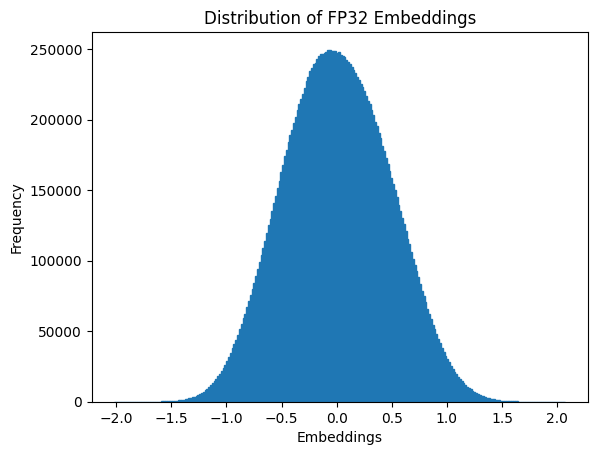

In [174]:
import matplotlib.pyplot as plt

# print histogram with the distribution of embeddings
plt.hist(embeddings.flatten(), bins=250, edgecolor='C0')
plt.xlabel('Embeddings')
plt.ylabel('Frequency')
plt.title('Distribution of FP32 Embeddings')
plt.show()

In [175]:
import numpy as np
np.array(embeddings[1000][:25]).reshape(5, 5)
embeddings[1000][:25]

array([-0.09335478, -0.5977759 ,  0.07759342, -0.20578717, -0.37967288,
        0.28887537, -0.31568018,  0.05953625, -0.3389973 ,  0.66473234,
       -0.4395536 , -0.49926084, -0.48578802, -0.3860658 , -0.37590823,
        1.0048815 ,  0.39084274, -0.070282  ,  0.1424382 ,  0.03794623,
       -0.10923411, -0.5995008 , -0.41349494,  0.02398205,  0.18937029],
      dtype=float32)

In [176]:
import numpy as np
np.array(int8_embeddings[1000][:25]).reshape(5, 5)

array([[ 20,   7, -65, -59, -26],
       [  8, -25,  74, -61,  34],
       [ 10, -19,  10, -65, -16],
       [  6,  56, -10,  23,  26],
       [ 39, -16,  21,  43, -36]], dtype=int8)

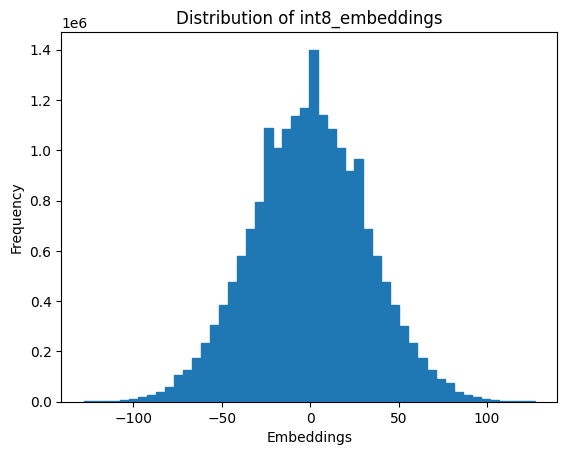

In [177]:
import matplotlib.pyplot as plt

# print histogram with the distribution of embeddings
plt.hist(int8_embeddings.flatten(), bins=50, edgecolor='C0')
plt.xlabel('Embeddings')
plt.ylabel('Frequency')
plt.title('Distribution of int8_embeddings')
plt.show()

----

In [ ]:
embeddings = model.encode(ds['train']['title'] + ': ' + ds['train']['abstract'],
                          batch_size=64,
                          show_progress_bar=True)

In [ ]:
from datasets import load_dataset
import pandas as pd

corpus = load_dataset("dcarpintero/arxiv.cs.CL.25k", split="train[:1000]")["question"]

ARXIV_JSON='./arxiv.cs.CL.25k.desc.json'
ARXIV_EMBEDDINGS_JSONL='./arxiv.cs.CL.embeddings.25k.jina.jsonl'
BATCH_SIZE=64

df = pd.read_json(ARXIV_JSON)
embeddings = model.encode(df['title'] + ': ' + df['abstract'],
                          batch_size=BATCH_SIZE,
                          show_progress_bar=True)
embeddings.shape

Batches:   0%|          | 0/393 [00:00<?, ?it/s]

(25107, 768)

In [ ]:
from datasets import Dataset

df['embeddings'] = embeddings.tolist()
df.to_json(ARXIV_EMBEDDINGS_JSONL, orient='records', lines=True)

In [ ]:
ds = Dataset.from_pandas(df)
ds

Dataset({
    features: ['id', 'doc_url', 'title', 'publication_date', 'update_date', 'authors', 'category_primary', 'category_all', 'abstract', 'embeddings'],
    num_rows: 25107
})

As an alternative you might just load the prepared dataset with embeddings from HuggingFace.

In [ ]:
from datasets import load_dataset
import tqdm as notebook_tqdm

ds_fp32 = load_dataset("dcarpintero/arxiv.cs.CL.25k.embeddings.jina", split="train")

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
ds_fp32

Dataset({
    features: ['id', 'doc_url', 'title', 'publication_date', 'update_date', 'authors', 'category_primary', 'category_all', 'abstract', 'embeddings'],
    num_rows: 10000
})

## 2. Projecting Embeddings for Dimensionality Reduction

We then project our (`title:abstract`) embeddings pairs from a high-dimensional space (768) to a lower-dimensional one (5) using
[dimensionality reduction](https://en.wikipedia.org/wiki/Dimensionality_reduction). This process will reduce the computational complexity and memory usage during clustering.

To implement this step, we use [UMAP](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction#Uniform_manifold_approximation_and_projection) [1], a popular technique known for its effectiveness in preserving both the local and global data structures. In practice, this makes it a preferred choice for handling complex datasets with high-dimensional embeddings.

In [203]:
import umap

umap_reducer = umap.UMAP(n_neighbors=100,
                         n_components=5,
                         min_dist=0.1,
                         metric='cosine')

#umap_embedding = umap_reducer.fit_transform(ds['embeddings'])
umap_embedding = umap_reducer.fit_transform(int8_embeddings)

In our implementation, we configure UMAP with:
- `n_neighbors=100` to consider 100 nearest neighbors for each point (arXiv publication);
- `n_components=5` to reduce the embeddings from 768 to 5 dimensions;
- `min_dist=0.1` to maintain a balance between the local and global structure; and,
- `metric='cosine'` to measure the distance between points using the cosine similarity metric.

Note that when we apply HDBSCAN clustering in the next step, the clusters found will be influenced by how UMAP preserved the local structures. A smaller `n_neighbors` value means UMAP will focus more on local structures, whereas a larger value allows to capture more global representations, which might be beneficial for understanding overall patterns in the data.

## 3. Semantic Clustering

This section shows how to use the reduced (`title:abstract`) embeddings pairs as input features of a clustering algorithm. This allows for the identification of related categories based on the distance between the provided embeddings.

We have opted for [HDBSCAN](https://en.wikipedia.org/wiki/HDBSCAN) (Hierarchical Density-Based Spatial Clustering of Applications with Noise) [2], an advanced clustering algorithm that extends DBSCAN by adapting to varying density clusters. Unlike K-Means which requires pre-specifying the number of clusters, HDBSCAN has only one important hyperparameter, `n`, which establishes the minimum number of examples to include in a cluster. As a density-based method, it can also detect outliers in the data.

HDBSCAN works by first transforming the data space according to the density of the data points, making denser regions (areas where data points are close together in high numbers) more attractive for cluster formation. The algorithm then builds a hierarchy of clusters based on the minimum cluster size established by the hyperparameter `n`. This allows it to distinguish between noise (sparse areas) and dense regions (potential clusters). Finally, HDBSCAN condenses this hierarchy to derive the most persistent clusters, efficiently identifying clusters of different densities and shapes.

Note that while we define a minimum cluster size similar to the number of neighbors in UMAP, in practice they do not need to be equal.

In [204]:
import hdbscan

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=100,
                                metric='euclidean',
                                cluster_selection_method='leaf') # 'eom'
clusters = hdbscan_model.fit_predict(umap_embedding)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


We prepare the dataset for visualization by further reducing the number of dimensions, in this case from '5' to '2'.

In [205]:
import pandas as pd

#reduced_embeddings = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, metric='cosine').fit_transform(ds['embeddings'])
reduced_embeddings = umap.UMAP(n_neighbors=100, n_components=2, min_dist=0.1, metric='cosine').fit_transform(int8_embeddings)
df = pd.DataFrame(reduced_embeddings, columns=['x', 'y'])
df['cluster'] = clusters

In [206]:
df['title'] = ds['title']
df['publication_date'] = ds['publication_date']

df = df[df['cluster'] != -1] # remove outliers

In [207]:
df.head(10)

x         y  cluster  \
1    8.523047  7.626181       22   
2    5.508401  1.329766        1   
4    5.443508  1.439796        1   
5    9.831388  5.005491       23   
6    3.687045  5.783087       21   
10   3.736936  2.673692        9   
12   9.691938  2.384762       33   
13   5.986225  6.404018        6   
14   6.905353  2.616482       24   
15  10.365292  5.395438       15   

                                                title      publication_date  
1   InternLM-XComposer-2.5: A Versatile Large Visi...  2024-07-03T17:59:21Z  
2   BACON: Supercharge Your VLM with Bag-of-Concep...  2024-07-03T17:55:27Z  
4   LLM Internal States Reveal Hallucination Risk ...  2024-07-03T17:08:52Z  
5   Evaluating Automatic Metrics with Incremental ...  2024-07-03T17:04:17Z  
6   How Similar Are Elected Politicians and Their ...  2024-07-03T16:36:26Z  
10  Single Character Perturbations Break LLM Align...  2024-07-03T16:03:10Z  
12    How Does Quantization Affect Multilingual LLMs?  2024-07-03T15:39:40Z  
13  CiteAssist: A System for Automated Preprint Ci...  2024-07-03T15:18:29Z  
14  Fine-Tuning with Divergent Chains of Thought B...  2024-07-03T15:01:18Z  
15  Investigating Decoder-only Large Language Mode...  2024-07-03T14:42:49Z

In [208]:
# number of clusters (32)
len(df['cluster'].unique())


34

## 4. Topic Modeling with LLMs

Having performed the clustering step, we now illustrate how to identify the topic of each cluster by combining an LLM such as [Mistral-7B-Instruct](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3) with [Pydantic](https://docs.pydantic.dev/) and [LangChain](https://www.langchain.com/) to create a topic modeling pipeline.

In [24]:
%pip install huggingface_hub langchain langchain_huggingface --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 17.9 MB/s eta 0:00:00


### 4.1 Pydantic Model

[Pydantic Models](https://docs.pydantic.dev/latest/concepts/models/) are classes that derive from `pydantic.BaseModel`, defining fields as type-annotated attributes. They bear a strong resemblance to `Python` dataclasses. However, they have been designed with subtle but significant differences that optimize various operations such as validation, serialization, and `JSON` schema generation. Our `Topic` class defines a field named `category`. This will generate output in a structured format, rather than a free-form text block, facilitating easier processing and analysis of the topic modeling results.

In [25]:
from pydantic import BaseModel, Field

class Topic(BaseModel):
    """
    Pydantic Model to generate an structured Topic Model
    """
    label: str = Field(..., description="Identified topic")

### 4.2 LangChain Prompt Template

[LangChain Prompt Templates](https://python.langchain.com/v0.2/docs/concepts/#prompt-templates) are pre-defined recipes for generating prompts for language models.

In [26]:
from langchain_core.prompts import PromptTemplate

topic_prompt = """
    You are a helpful Research Engineer. Your task is to analyze a set of research paper titles related to Natural Language Processing and
    determine the overarching topic of the cluster. Based on the titles provided, you should identify and label the most relevant topic.
    The response should be concise, clearly stating the single  identified topic. Format your response in JSON as indicated in the 'EXPECTED OUTPUT' section below.
    No additional information or follow-up questions are needed.

    EXPECTED OUTPUT:
    {{"label": "Topic Name"}}

    TITLES:
    {titles}
    """

### 4.3 Inference of Topic Identification

This section illustrates how to compose a topic pipeline using the [LangChain Expression Language (LCEL)](https://python.langchain.com/v0.2/docs/concepts/#langchain-expression-language-lcel).

In [27]:
import os
from google.colab import userdata
os.environ["HUGGINGFACEHUB_API_TOKEN"] = userdata.get('HUGGINGFACEHUB_API_TOKEN')

In [28]:
import os

from langchain.chains import LLMChain
from langchain_huggingface import HuggingFaceEndpoint
from langchain_core.output_parsers import PydanticOutputParser

from typing import List

def TopicModeling(titles: List[str]) -> str:
    """
    Infer the common topic of the given titles w/ LangChain, Pydantic, Mistral-7B-Instruct
    """
    repo_id = "mistralai/Mistral-7B-Instruct-v0.3"
    llm = HuggingFaceEndpoint(
        repo_id=repo_id,
        temperature=0.2,
        huggingfacehub_api_token=os.environ["HUGGINGFACEHUB_API_TOKEN"]
    )
    prompt = PromptTemplate.from_template(topic_prompt)
    parser = PydanticOutputParser(pydantic_object=Topic)

    topic_chain = prompt | llm | parser
    return topic_chain.invoke({"titles": titles})

To enable the model to infer the topic of each cluster, we provide a random subset of 25 paper titles from each cluster as input.

In [209]:
%%capture
topics = []
for i, cluster in df.groupby('cluster'):
    titles = cluster['title'].sample(25).tolist()
    topic = TopicModeling(titles)
    topics.append(topic.label)

Lets assign each arXiv publication to each cluster, and see what are the top 15 topics.

In [210]:
n_clusters = len(df['cluster'].unique())

topic_map = dict(zip(range(n_clusters), topics))
df['topic'] = df['cluster'].map(topic_map)

In [ ]:
df['topic'].value_counts()

topic
Multimodal Vision-Language Processing                   1313
Speech Recognition and Synthesis                        1200
Medical NLP                                             1070
Multilingual Language Models and Machine Translation     860
Attacks on Large Language Models                         781
Knowledge Graphs                                         581
Mathematical Reasoning in Language Models                565
Bias in Language Models                                  429
Named Entity Recognition                                 371
Task-Oriented Dialogue Systems                           325
Fake News Detection                                      313
Large Language Model Alignment via Human Preference      310
Emotion Recognition and Analysis                         308
Transformers                                             275
Hate Speech Detection                                    257
Aspect-Based Sentiment Analysis                          235
LLM-based Agents  

In [200]:
df['topic'].value_counts()

topic
Speech Recognition                                              1236
Multimodal Learning                                             1203
Medical Natural Language Processing                             1117
Multilingual Language Modeling and Processing                   1002
Reasoning Ability of Language Models                             742
Bias and Fairness in NLP                                         550
Task-Oriented Dialogue Systems                                   470
Transformers                                                     322
Emotion Recognition in Speech and Text                           300
Language Model Alignment                                         298
Question Answering with Knowledge Graphs                         289
Offensive Language Detection                                     268
Multi-document Summarization                                     250
Prompting Techniques in LLMs                                     246
Hallucination in Language Mo

In [211]:
df['topic'].value_counts()

topic
Automatic Speech Recognition                                1254
Multimodal Natural Language Processing                      1184
Natural Language Processing in Medicine                     1069
Machine Translation                                          998
Mathematical Reasoning in Large Language Models              892
Task-Oriented Dialogue Systems                               498
Gender Bias in NLP                                           432
Open-Domain Question Answering                               379
Transformers                                                 328
Reinforcement Learning for Human Alignment                   301
Speech Emotion Recognition                                   296
Natural Language Processing for AI Agents                    274
Hate Speech Detection                                        272
Prompt Engineering                                           255
Hallucination in Large Language Models                       245
Abstractive Multi-d

In [212]:
df.shape

(11674, 6)

## 5. Visualization

In [35]:
%pip install vegafusion[embed]>=1.5.0

In [36]:
import altair as alt
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [ ]:
chart = alt.Chart(df).mark_circle(size=5).encode(
    x='x',
    y='y',
    color='topic:N',
    tooltip=['title', 'topic']
).interactive().properties(
    title='25K arXiv Publications | Clustering and Topic Modeling | Jina-Embeddings | Mistral-7B',
    width=600,
    height=400,
)
chart.display()

alt.Chart(...)

In [214]:
custom_color_palette = [
    '#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
    '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
    '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
    '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5',
    '#393b79', '#5254a3', '#6b6ecf', '#9c9ede', '#637939',
    '#8ca252', '#b5cf6b', '#cedb9c', '#8c6d31', '#bd9e39',
    '#e7ba52', '#e7cb94', '#843c39', '#ad494a', '#d6616b'
]

chart = alt.Chart(df).mark_circle(size=5).encode(
    x='x',
    y='y',
    #color='topic:N',
    color=alt.Color('topic:N', scale=alt.Scale(range=custom_color_palette)),
    tooltip=['title', 'topic']
).interactive().properties(
    title='25K arXiv Publications | Clustering and Topic Modeling | Jina-Embeddings | Mistral-7B',
    width=600,
    height=400,
)
chart.display()

alt.Chart(...)

In [64]:
chart = alt.Chart(df).mark_circle(size=5).encode(
    x='x',
    y='y',
    color='topic:N',
    tooltip=['title', 'topic']
).interactive().properties(
    title='25K arXiv Publications | Clustering and Topic Modeling | Jina-Embeddings | Mistral-7B',
    width=600,
    height=400,
)
chart.display()

alt.Chart(...)

----